# Prepare for training I-10 Broadway Curve

### Training input
- features per TMC segment per time interval, including event counts for each type, and segment length

### Training output
- INRIX segment-wise travel time

In [1]:

from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates

# Display all columns
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# save I-10 broadway data
data_path = Path('../database/i10-broadway')
data_path.mkdir(parents=True, exist_ok=True)

df_events = pd.read_parquet(data_path / 'events.parquet')
df_inrix = pd.read_parquet(data_path / 'inrix.parquet')
df_tmc = pd.read_parquet(data_path / 'tmc.parquet')

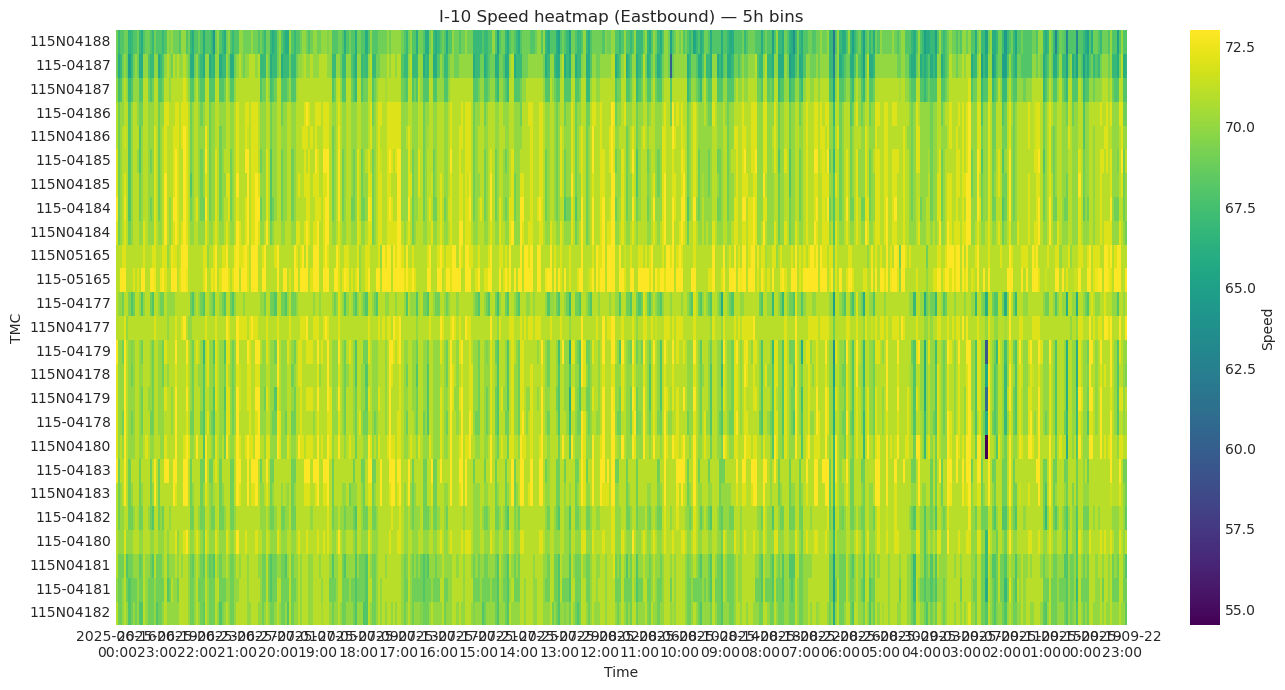

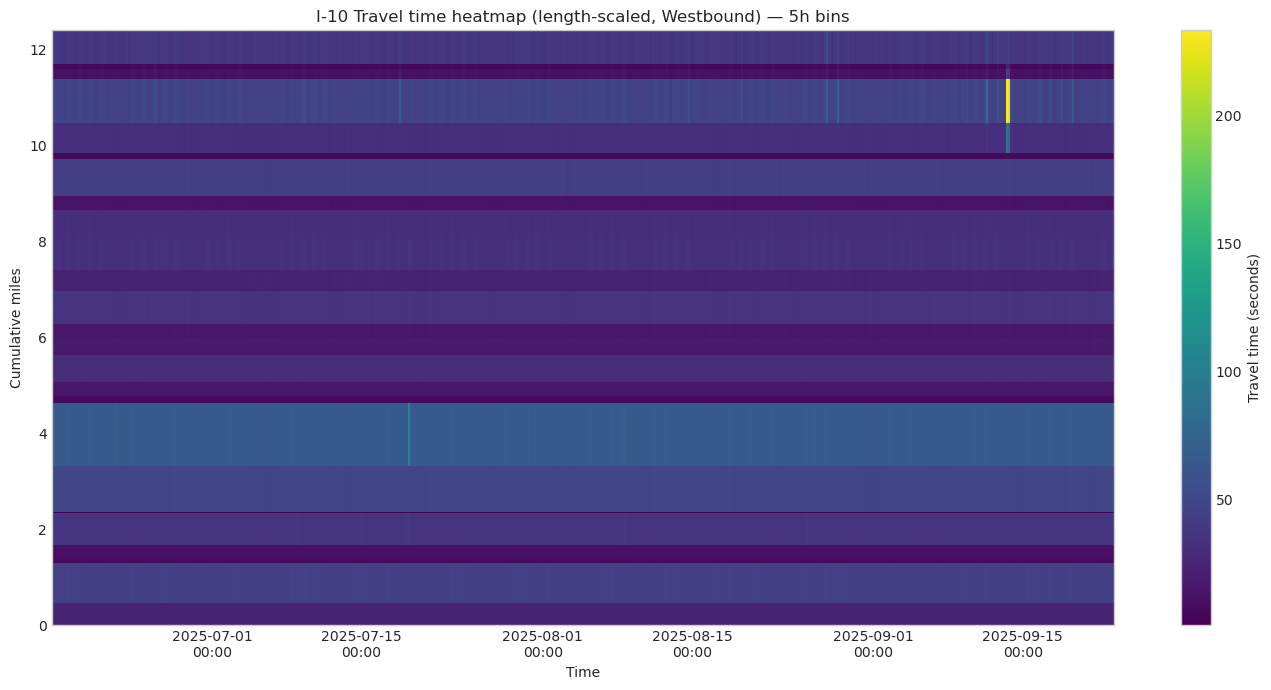

In [14]:
# Visualize travel time in df_inrix
# filter data by eastbound/westbound
# aggregate travel time to 1hr intervals
# plot travel time over time in 2d heatmap - x=time, y=tmc (optionally scaled by segment length)


def plot_travel_time_heatmap(
    df_inrix,
    df_tmc,
    direction='E',
    metric='travel_time',      # 'travel_time' or 'speed'
    interval='1hr',            # '1hr' or '5min' (or pandas offsets like '1H','5T')
    cmap='viridis',
    vmin=None, vmax=None,
    agg='median',
    scale_by_length=False
):
    # Validate required columns (do not modify inputs)
    for col in ['tmc_code', 'measurement_tstamp']:
        if col not in df_inrix.columns:
            raise ValueError(f"df_inrix missing required column: {col}")
    # Metric -> column mapping
    metric = str(metric).lower()
    metric_map = {
        'travel_time': ('travel_time_seconds', 'Travel time (seconds)'),
        'speed': ('speed', 'Speed')
    }
    if metric not in metric_map:
        raise ValueError("metric must be 'travel_time' or 'speed'")
    value_col, cbar_label = metric_map[metric]
    if value_col not in df_inrix.columns:
        raise ValueError(f"df_inrix missing required column for metric: {value_col}")

    for col in ['tmc', 'miles', 'direction']:
        if col not in df_tmc.columns:
            raise ValueError(f"df_tmc missing required column: {col}")

    # Normalize inputs
    # freq = _normalize_interval(interval)
    freq = interval
    def _normalize_dir(x: str):
        if pd.isna(x):
            return None
        s = str(x).upper()
        if 'EAST' in s:
            return 'E'
        if 'WEST' in s:
            return 'W'
        return None


    # Allowed TMCs for this direction (no modification to df_tmc)
    dir_series = df_tmc['direction'].map(_normalize_dir)
    allowed_tmc = df_tmc.loc[dir_series == direction, 'tmc']
    # Filter df_inrix rows by allowed TMCs and valid timestamps/values (no modification to df_inrix)
    base_mask = (
        df_inrix['tmc_code'].isin(allowed_tmc) &
        df_inrix['tmc_code'].notna() &
        df_inrix['measurement_tstamp'].notna()
    )
    s_ts = pd.to_datetime(df_inrix.loc[base_mask, 'measurement_tstamp'], errors='coerce', utc=True)
    s_val = df_inrix.loc[base_mask, value_col]
    s_tmc = df_inrix.loc[base_mask, 'tmc_code']
    valid = s_ts.notna() & s_val.notna()
    if not valid.any():
        raise ValueError("No valid rows after filtering by direction and timestamp/value availability.")

    # Build a minimal temporary frame for aggregation (small and transient)
    tmp = pd.DataFrame({
        'time_bin': s_ts[valid].dt.floor(freq),
        'tmc_code': s_tmc[valid].values,
        value_col: s_val[valid].values
    })

    # Aggregate
    agg_func = 'median' if agg == 'median' else ('mean' if agg == 'mean' else agg)
    pivot = tmp.groupby(['time_bin', 'tmc_code'])[value_col].agg(agg_func).unstack('tmc_code')
    if pivot.empty:
        raise ValueError("No data after filtering/aggregation. Check direction and date ranges.")

    # Order TMCs by longitude (no merge into df_inrix)
    order_meta = (
        df_tmc.loc[df_tmc['tmc'].isin(pivot.columns), ['tmc', 'start_longitude']]
        .dropna()
        .drop_duplicates()
    )
    if not order_meta.empty:
        ascending = True if direction == 'E' else False
        ordered_tmc = order_meta.sort_values('start_longitude', ascending=ascending)['tmc'].tolist()
        leftover = [c for c in pivot.columns if c not in ordered_tmc]
        ordered_tmc += sorted(leftover)
    else:
        ordered_tmc = sorted(pivot.columns.tolist())
    pivot = pivot.reindex(columns=ordered_tmc)

    # Regularize time index on the result only
    start, end = pivot.index.min(), pivot.index.max()
    full_times = pd.date_range(start, end, freq=freq)
    pivot = pivot.reindex(index=full_times)

    # Seaborn heatmap (equal-height cells)
    if not scale_by_length:
        fig, ax = plt.subplots(figsize=(14, 7))
        sns.heatmap(
            pivot.T, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
            cbar_kws={'label': cbar_label},
            mask=pivot.T.isna()
        )
        title_metric = "Travel time" if metric == 'travel_time' else "Speed"
        ax.set_title(f"I-10 {title_metric} heatmap ({'Eastbound' if direction=='E' else 'Westbound'}) — {freq} bins")
        ax.set_xlabel("Time")
        ax.set_ylabel("TMC")
        n_times = len(pivot.index)
        step = max(1, n_times // 24)
        xticks = np.arange(0, n_times, step)
        ax.set_xticks(xticks + 0.5)
        ax.set_xticklabels([t.strftime('%Y-%m-%d\n%H:%M') for t in pivot.index[::step]], rotation=0)
        plt.tight_layout()
        plt.show()
        return

    # Length-scaled cells using miles (only from df_tmc)
    lengths = (
        df_tmc.loc[df_tmc['tmc'].isin(ordered_tmc)]
              .drop_duplicates(subset=['tmc'])
              .set_index('tmc')
              .reindex(ordered_tmc)['miles']
              .astype(float)
              .fillna(0.01)
    )
    y_edges = np.r_[0.0, np.cumsum(lengths.values)]
    x_edges_dt = np.r_[full_times.values, (full_times[-1] + pd.to_timedelta(freq)).to_datetime64()]
    x_edges = mdates.date2num(pd.to_datetime(x_edges_dt))
    Z = pivot.T.values

    fig, ax = plt.subplots(figsize=(14, 7))
    X, Y = np.meshgrid(x_edges, y_edges)
    pcm = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label=cbar_label)
    title_metric = "Travel time" if metric == 'travel_time' else "Speed"
    ax.set_title(f"I-10 {title_metric} heatmap (length-scaled, {'Eastbound' if direction =='E' else 'Westbound'}) — {freq} bins")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulative miles")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.tight_layout()
    plt.show()


# Examples:
plot_travel_time_heatmap(df_inrix, df_tmc, direction='E', metric='speed', interval='5h', scale_by_length=False)
plot_travel_time_heatmap(df_inrix, df_tmc, direction='W', metric='travel_time', interval='5h', scale_by_length=True)

In [3]:
# 5 custom impact categories with renamed short labels
event_mapping = {
    # 1. Major Lane-Blocking
    "crashRlane": "cat_major",
    "crashLlane": "cat_major",
    "crashHOV": "cat_major",
    "C34Rlane": "cat_major",
    "C34leftLanes": "cat_major",
    "C34HOVlane": "cat_major",
    "Freewayclosed": "cat_major",
    "RoadClosedDueToCrash": "cat_major",
    "AccidentIncident": "cat_major",
    "accident": "cat_major",
    "CrashMedian": "cat_major",
    "crashBIntersection": "cat_major",

    # 2. Shoulder/Ramp Incidents (Minor)
    "C34Rshoulder": "cat_minor",
    "C34Lshoulder": "cat_minor",
    "Crash on right shoulder": "cat_minor",
    "CrashLshoulder": "cat_minor",
    "DebrisRshoulder": "cat_minor",
    "debrisLshoulder": "cat_minor",
    "vehicleOnFire": "cat_minor",
    "pedestrianOnRoadway": "cat_minor",
    "animalOnRoadway": "cat_minor",
    "C34exit": "cat_minor",
    "TC34EXB": "cat_minor",
    "C34onramp": "cat_minor",
    "crashBOnramp": "cat_minor",
    "crashExit": "cat_minor",
    "crashBExit": "cat_minor",
    "crashOnramp": "cat_minor",
    "TC34ONB": "cat_minor",

    # 3. Roadwork/Planned Closures
    "leftlanes": "cat_closure",
    "rightlanes": "cat_closure",
    "LeftLane": "cat_closure",
    "rightlane": "cat_closure",
    "shoulderclosed": "cat_closure",
    "exitrestricted": "cat_closure",
    "exitclosed": "cat_closure",
    "hovrampclosed": "cat_closure",
    "ramp2westclosed": "cat_closure",
    "ramp2eastclosed": "cat_closure",
    "patching": "cat_closure",

    # 4. Road Obstructions / Debris
    "debrisLlane": "cat_obstruction",
    "debrisRlane": "cat_obstruction",
    "debrisinroad": "cat_obstruction",
    "debrisClane": "cat_obstruction",
    "Potholes": "cat_obstruction",
    "DeadAnimalRoad": "cat_obstruction",
    "Graffiti": "cat_obstruction",
    "guardrail": "cat_obstruction",
    "fencedamage": "cat_obstruction",

    # 5. Infrastructure / Miscellaneous
    "signaltiming": "cat_misc",
    "SignalIssue": "cat_misc",
    "SignalRedbulb": "cat_misc",
    "signdamaged": "cat_misc",
    "ITS Equipment Damage": "cat_misc",
    "TDMG": "cat_misc",
    "T1018SR": "cat_misc",
    "TDMGLEAK": "cat_misc",
    "TDEBRISRM": "cat_misc",
    "TDEBRISLM": "cat_misc",
    "TDEBRISCM": "cat_misc",
    "TDEBRISONB": "cat_misc",
    "TC34I": "cat_misc",
}

# apply to your dataframe
df_events["cat_event_type"] = df_events["EventSubType"].map(event_mapping).fillna("cat_misc")

In [4]:
# Compute duration (minutes)
def compute_duration(row):
    if row["EventType"] in ['closures', 'roadwork']:
        if pd.notnull(row["StartDate"]) and pd.notnull(row["PlannedEndDate"]):
            return (row["PlannedEndDate"] - row["StartDate"]) / 60.0
    elif row["EventType"] == 'accidentsAndIncidents':
        if pd.notnull(row["Reported"]) and pd.notnull(row["LastUpdated"]):
            return (row["LastUpdated"] - row["Reported"]) / 60.0
    return None
df_events["duration"] = df_events.apply(compute_duration, axis=1)

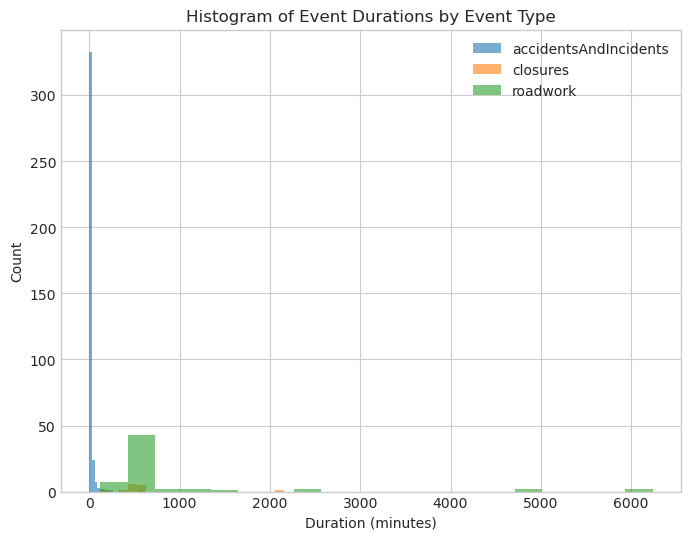

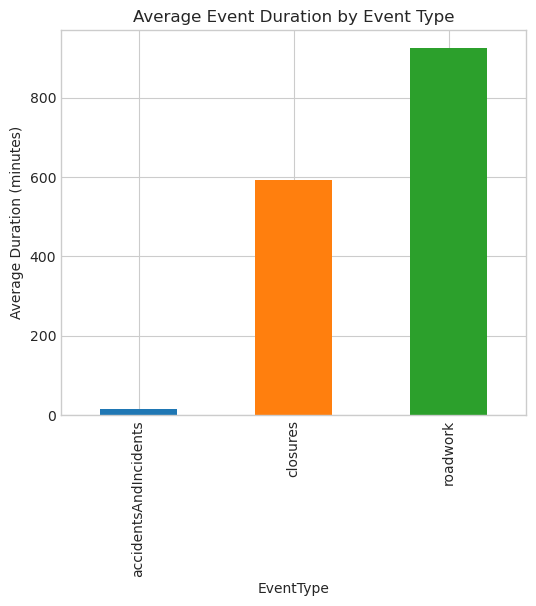

In [17]:

# -------------------
# Histogram of durations by event type
# -------------------
plt.figure(figsize=(8,6))
for etype, subset in df_events.groupby("EventType"):
    plt.hist(
        subset["duration"].dropna(),
        bins=20,
        alpha=0.6,
        label=etype
    )

plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.title("Histogram of Event Durations by Event Type")
plt.legend()
plt.show()

# -------------------
# Bar plot of average durations by event type
# -------------------
avg_durations = df_events.groupby("EventType")["duration"].mean()

plt.figure(figsize=(6,5))
avg_durations.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.ylabel("Average Duration (minutes)")
plt.title("Average Event Duration by Event Type")
plt.show()

In [5]:
# Prepare for training data X from df_events and df_inrix
# drop columns from df_inrix:'reference_speed','confidence_score', 'cvalue', 'Inrix 2013','Inrix 2019'
# aggregate df_inrix speed and travel time to [5-minute] intervals for each tmc_code, make the interval a parameter, keep the first from other columns

interval = '1h'  # parameterizable

# Drop optional columns if present
cols_to_drop = ['confidence_score', 'cvalue', 'Inrix 2013', 'Inrix 2019']
df_inrix = df_inrix.drop(columns=[c for c in cols_to_drop if c in df_inrix.columns], errors='ignore')

# Require time and TMC columns
time_col = 'measurement_tstamp'
group_col = 'tmc_code'
if time_col not in df_inrix.columns or group_col not in df_inrix.columns:
    raise ValueError(f"df_inrix must contain '{time_col}' and '{group_col}'")

# Build aggregation map
value_cols = [c for c in ['speed', 'travel_time_seconds','reference_speed'] if c in df_inrix.columns]
agg_map = {c: 'mean' for c in value_cols}
other_cols = [c for c in df_inrix.columns if c not in set(value_cols + [time_col, group_col])]
for c in other_cols:
    agg_map[c] = 'first'

# Compute time bins and aggregate per TMC and bin
tmp = df_inrix.copy()
tmp['time_bin'] = pd.to_datetime(tmp[time_col], unit='s', errors='coerce', utc=True).dt.floor(interval)
tmp = tmp.dropna(subset=['time_bin', group_col])

X = (
    tmp
    .groupby([group_col, 'time_bin'], as_index=False)
    .agg(agg_map)
    .sort_values([group_col, 'time_bin'])
    .set_index([group_col, 'time_bin'])
)


In [6]:
X

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 00:00:00+00:00  70.133333             7.598167   
          2025-06-16 01:00:00+00:00  69.583333             7.665000   
          2025-06-16 02:00:00+00:00  67.300000             7.950667   
          2025-06-16 03:00:00+00:00  71.933333             7.411000   
          2025-06-16 04:00:00+00:00  71.816667             7.422000   
...                                        ...                  ...   
115P05165 2025-09-23 05:00:00+00:00  72.483333            14.144333   
          2025-09-23 06:00:00+00:00  71.100000            14.419667   
          2025-09-23 07:00:00+00:00  70.700000            14.500667   
          2025-09-23 08:00:00+00:00  70.133333            14.622000   
          2025-09-23 09:00:00+00:00  70.500000            14.547500   

                                     reference_speed  
tmc_code  time_bin                                    
115+04177 2025-06-16 00:00:00+00:00             70.0  
          2025-06-16 01:00:00+00:00             70.0  
          2025-06-16 02:00:00+00:00             70.0  
          2025-06-16 03:00:00+00:00             70.0  
          2025-06-16 04:00:00+00:00             70.0  
...                                              ...  
115P05165 2025-09-23 05:00:00+00:00             70.0  
          2025-09-23 06:00:00+00:00             70.0  
          2025-09-23 07:00:00+00:00             70.0  
          2025-09-23 08:00:00+00:00             70.0  
          2025-09-23 09:00:00+00:00             70.0  

[119291 rows x 3 columns]

In [7]:
# ----------------------------
# Add event-overlap features
# match tmc_code in df_inrix with near_tmc from df_events, if the event has any time overlap with this time interval.
# time overlap is defined similar to the start and end date used to calculate duration
# ----------------------------

# Normalize event type and parse timestamps (UTC)
etype = df_events['EventType'].astype(str).str.strip().str.lower()
s_startdate = pd.to_datetime(df_events.get('StartDate'), unit='s', errors='coerce', utc=True)
s_plannedend = pd.to_datetime(df_events.get('PlannedEndDate'), unit='s', errors='coerce', utc=True)
s_reported   = pd.to_datetime(df_events.get('Reported'), unit='s', errors='coerce', utc=True)
s_lastupdate = pd.to_datetime(df_events.get('LastUpdated'), unit='s', errors='coerce', utc=True)

# Determine event windows per rules
is_plan = etype.isin(['closures', 'roadwork'])
is_inc  = etype.eq('accidentsandincidents')

event_start = pd.Series(pd.NaT, index=df_events.index, dtype='datetime64[s, UTC]')
event_end   = pd.Series(pd.NaT, index=df_events.index, dtype='datetime64[s, UTC]')

event_start[is_plan] = s_startdate[is_plan]
event_end[is_plan]   = s_plannedend[is_plan]
event_start[is_inc]  = s_reported[is_inc]
event_end[is_inc]    = s_lastupdate[is_inc]

# If end is missing, fall back to start (zero-length window)
event_end = event_end.fillna(event_start)

# Keep needed event fields and normalize near_tmc to string for matching
evt_cat_levels = ['cat_major','cat_minor','cat_closure','cat_obstruction','cat_misc']
events_proc = pd.DataFrame({
    'near_tmc_str': df_events['near_tmc'].astype(str),
    'event_start': event_start,
    'event_end': event_end,
    'cat': df_events.get('cat_event_type', 'cat_misc').astype(str),
    # 'duration': pd.to_numeric(df_events.get('duration'), errors='coerce')
}).dropna(subset=['near_tmc_str', 'event_start', 'event_end'])
events_proc['cat'] = events_proc['cat'].where(events_proc['cat'].isin(evt_cat_levels), 'cat_misc')
# events_proc['duration'] = events_proc['duration'].fillna(0.0).astype(float)

In [8]:
# Build event features per (tmc_code, time_bin)
evt_cols = ['evt_duration'] + [f'evt_{c}' for c in evt_cat_levels]
evt_parts = []

tmcs = X.index.get_level_values(group_col).unique().sort_values()
for tmc in tmcs:
    # bins for this TMC
    b_times = X.loc[tmc].index if (tmc in X.index.get_level_values(0)) else pd.Index([], dtype='datetime64[s, UTC]')
    if len(b_times) == 0:
        continue
    b_start = pd.DatetimeIndex(b_times)
    b_end = b_start + pd.to_timedelta(interval)

    # events for this near_tmc
    edf = events_proc[events_proc['near_tmc_str'] == str(tmc)]
    if edf.empty:
        feat = pd.DataFrame(0, index=b_start, columns=evt_cols)
    else:
        e_start = edf['event_start'].to_numpy()
        e_end   = edf['event_end'].to_numpy()
        cat_vals = edf['cat'].to_numpy()

        # overlap: (bin_start < event_end) & (bin_end > event_start)
        bs = b_start.to_numpy()[:, None]
        be = b_end.to_numpy()[:, None]
        overlap = (bs < e_end[None, :]) & (be > e_start[None, :])

        # per-category counts for each bin
        data = {}
        for c in evt_cat_levels:
            mask_c = (cat_vals[None, :] == c)
            data[f'evt_{c}'] = (overlap & mask_c).sum(axis=1).astype(int)

        feat = pd.DataFrame(data, index=b_start)

    feat.index.name = 'time_bin'
    feat[group_col] = tmc
    feat = feat.reset_index().set_index([group_col, 'time_bin']).sort_index()
    evt_parts.append(feat)

if evt_parts:
    evt_df = pd.concat(evt_parts).sort_index()
else:
    # No events matched any TMC; create zeros for existing index
    print("No events matched any TMC; event features will be zero.")
    evt_df = pd.DataFrame(0, index=X.index, columns=evt_cols)

# Join event features to X_df
X = X.join(evt_df, how='right')
# ----------------------------

# Fold into 3D tensor: [tmc_code, time_bin, feature]
tmcs = X.index.get_level_values(group_col).unique().sort_values()
times = X.index.get_level_values('time_bin').unique().sort_values()
full_idx = pd.MultiIndex.from_product([tmcs, times], names=[group_col, 'time_bin'])
X_full = X.reindex(full_idx)

# Fill event features with 0; leave measurements as NaN if missing
X_full[evt_cols] = X_full[evt_cols].fillna(0)

# Ensure miles present for all (tmc,time)
miles_map = df_tmc.drop_duplicates('tmc').set_index('tmc')['miles'].astype(float)
X_full['miles'] = X_full.index.get_level_values(group_col).map(miles_map)

# Final feature list (measurements + event features + miles)
features = value_cols + evt_cols + ['miles']

X = X_full[features].to_numpy().reshape(len(tmcs), len(times), len(features))

# Keep references to indices and feature names for downstream use
X_tmc_index = tmcs.tolist()
X_time_index = pd.DatetimeIndex(times)  # UTC
X_features = features

print("X shape:", X.shape)
print("#TMC:", len(X_tmc_index), "#Time bins:", len(X_time_index), "Features:", X_features)


X shape: (50, 2386, 10)
#TMC: 50 #Time bins: 2386 Features: ['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration', 'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc', 'miles']


In [22]:
X_full[features].sum()

speed                  8.343970e+06
travel_time_seconds    3.053974e+06
evt_duration           0.000000e+00
evt_cat_major          1.080000e+02
evt_cat_minor          2.440000e+02
evt_cat_closure        5.300000e+02
evt_cat_obstruction    1.900000e+01
evt_cat_misc           4.100000e+01
miles                  5.895468e+04
dtype: float64

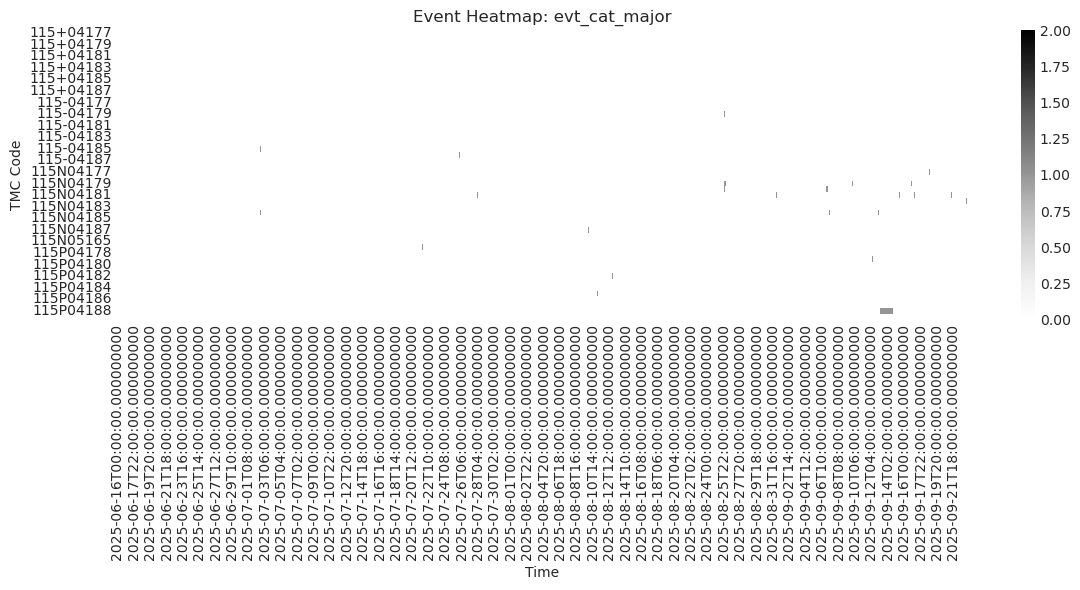

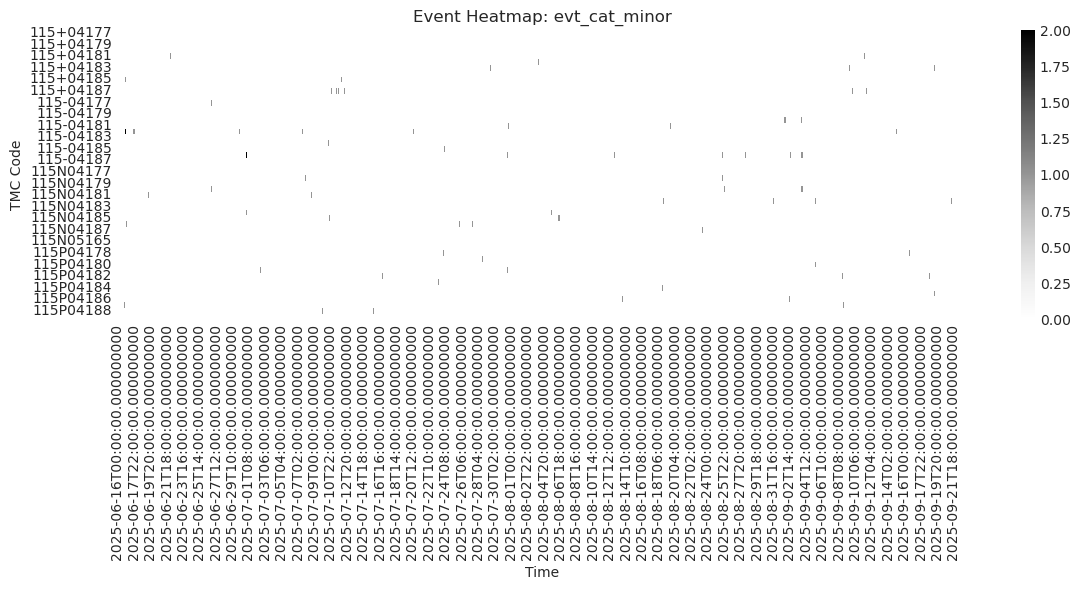

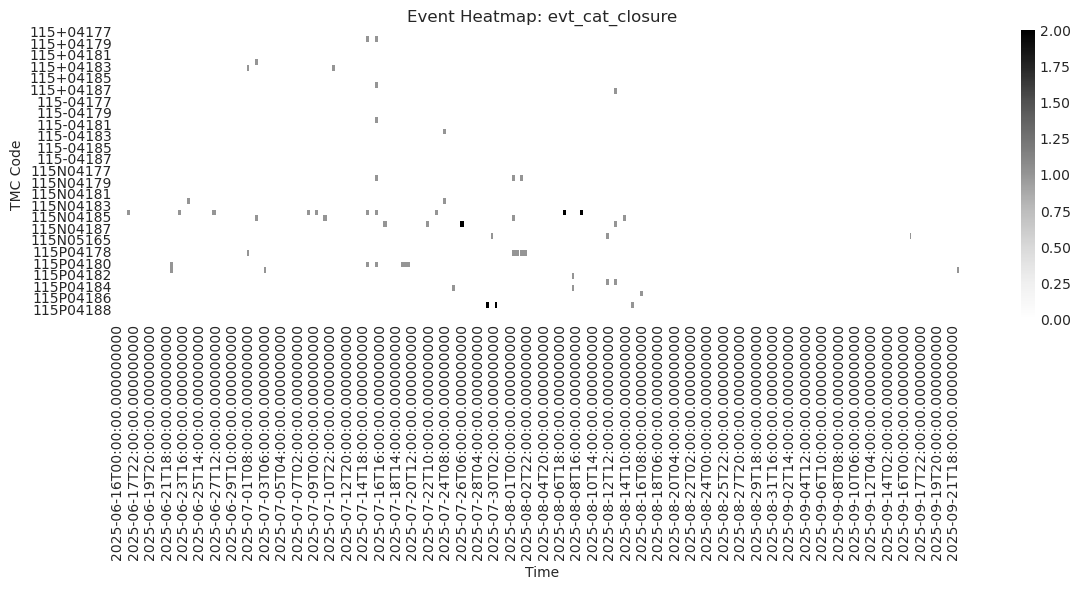

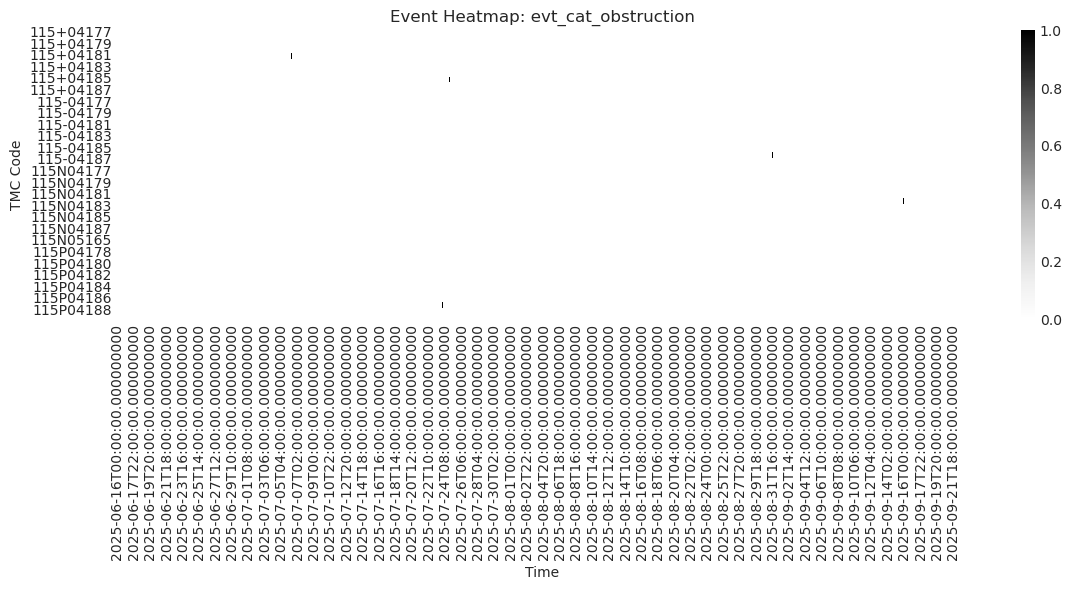

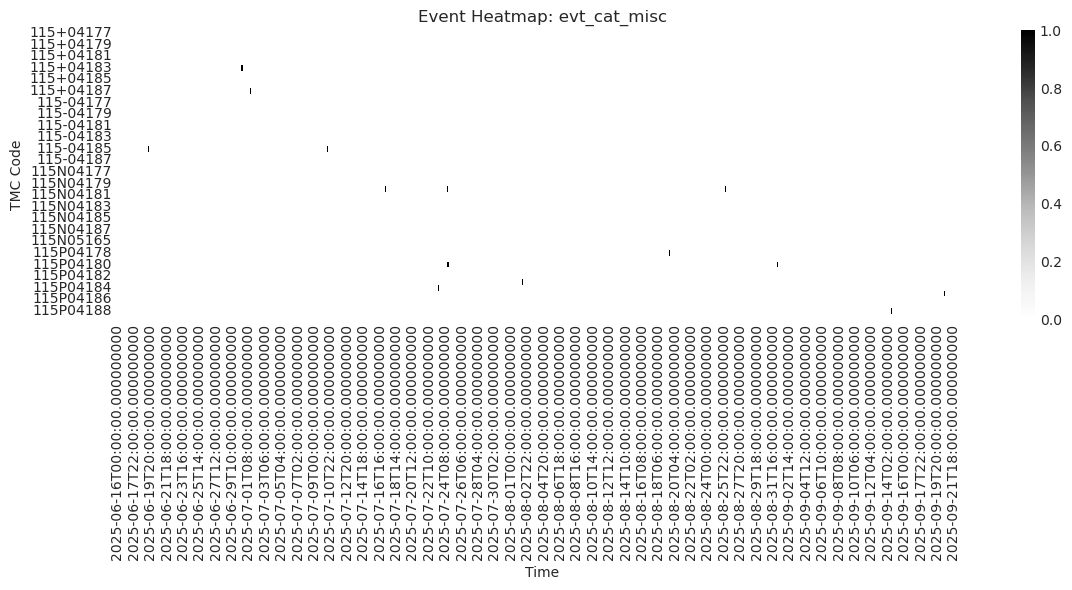

In [23]:
# plotting to see the event features over time and TMCs
# Example: aggregate by hour (optional)
X_hourly = (
    X_full
    .groupby([pd.Grouper(level='tmc_code'),
              pd.Grouper(level='time_bin', freq='1h')])
    .sum()
)
cols = ['evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
X_sel = X_hourly[cols]
for col in cols:
    data = X_sel[col].unstack(level='tmc_code').fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.T, cmap='Greys')
    plt.title(f"Event Heatmap: {col}")
    plt.xlabel("Time")
    plt.ylabel("TMC Code")
    plt.tight_layout()
    plt.show()

In [9]:
# ===== Fold into 3d tensor =====
# (n_tmc, n_time, n_features)

# Get unique levels
tmc_codes = X_full.index.get_level_values("tmc_code").unique()
time_bins = X_full.index.get_level_values("time_bin").unique()
features = X_full.columns

# Convert to 3D tensor
X_tensor = (
    X_full
    .to_numpy()
    .reshape(len(tmc_codes), len(time_bins), len(features))
)

print("Tensor shape:", X_tensor.shape)


Tensor shape: (50, 2386, 10)


In [11]:
# save data in .npz
np.savez_compressed(
    data_path / 'X_tensor_1h.npz',
    X_tensor=X_tensor
)
X_full.to_parquet(data_path / 'X_full_1h.parquet')